In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.ndimage as spim
import skimage
from skimage import io
import pickle as pk
import pandas as pd
from matplotlib import cm
from skimage.filters import threshold_otsu
import os
from skimage.measure import marching_cubes
from skimage.measure import mesh_surface_area
from pyevtk.hl import gridToVTK
import trimesh 

In [2]:
import tifffile as tif

In [3]:
def pkdump(var,path):
    with open(path,'wb') as f:
        pk.dump(var,f)

def pkload(path):
    with open(path,'rb') as f:
        var = pk.load(f)
    return var

In [4]:
def save_to_vtk(data, filepath):
    """
    save the 3d data to a .vtk file. 
    
    Parameters
    ------------
    data : 3d np.array
        3d matrix that we want to visualize
    filepath : str
        where to save the vtk model, do not include vtk extension, it does automatically
    """
    x = np.arange(data.shape[0]+1)
    y = np.arange(data.shape[1]+1)
    z = np.arange(data.shape[2]+1)
    gridToVTK(filepath, x, y, z, cellData={'data':data.copy()})

In [5]:
def vtksph(path,n_sph, radius, coord):
    with open(path,'w') as VTK:
        VTK.write('# vtk DataFile Version 3.0.\n')
        VTK.write('comment\n')
        VTK.write('ASCII\n\n')
        VTK.write('DATASET POLYDATA\n')
        VTK.write('POINTS %i double\n' %n_sph)
        for point in coord:
            VTK.write('%f %f %f\n' %(point[0], point[1], point[2]))
        
        VTK.write('\nPOINT_DATA %i\n' %n_sph)
        VTK.write('SCALARS radius double 1\n')
        VTK.write('LOOKUP_TABLE default\n')
        for r in radius:
            VTK.write('%f\n' %(r))

In [6]:
def binarize(im, threshold):
    boolean = im > threshold
    binarized = np.multiply(boolean, 1)
    return binarized

def por(mat):
    por = 1 - mat.mean()
    return por

In [7]:
def write_obj( filename, coord, radius, newBox, obj):
    
    obj_type = {'node': {'type': 1, 'columns': [ 'cx', 'cy', 'cz', 'r', 'idx' ]
                        },
                'edge': {'type': 5, 'columns':['sx','sy','sz','ex','ey','ez','r','idx']
                        }
        }[obj]
    
    if obj == 'edge':
        df = np.array([( item.flatten()) for item in coord ])
    else:
        df = coord
    
    df = np.insert( df, df.shape[-1], radius, axis=1)
    df = np.insert( df, df.shape[-1], range(len(df)), axis=1)
    df = pd.DataFrame( df, columns=obj_type['columns'])
    df = df.astype({ 'r': 'int64', 'idx': 'int64'})
    
    df_head = np.append( newBox[-1], [ len(coord), obj_type['type'] ]).astype(int)
    
    if not os.path.exists(filename):
        np.savetxt(filename, df_head.reshape(1, df_head.shape[0]), fmt='%d', delimiter=' ')
        df.to_csv(filename, mode='a', float_format='%.4f',sep=' ',index=False,header=False)
    else:
        with open(filename,'a') as f:
            np.savetxt(f,df_head.reshape(1, df_head.shape[0]), fmt='%d', delimiter=' ')
        df.to_csv(filename, mode='a', float_format='%.4f',sep=' ',index=False,header=False)

### im765

In [8]:
im765 = io.imread('./Al2O3_40ppi_plugim.tif')

In [9]:
im765.shape

(420, 420, 420)

In [10]:
im765.max()

255

In [11]:
im765 = (1 - im765/im765.max()).astype(np.uint8)

In [12]:
im765.mean()

0.7515953865673254

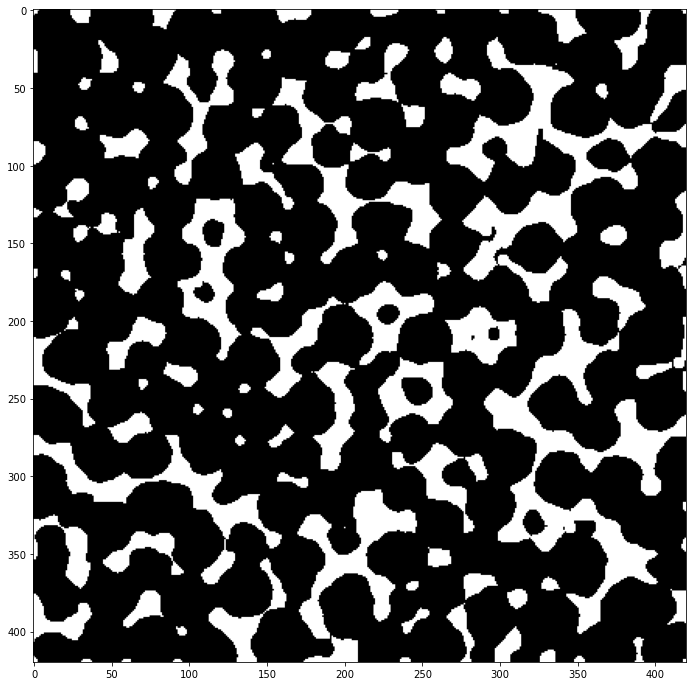

In [13]:
figf, axf = plt.subplots(figsize=(12,12))
axf.imshow(im765[250,:,:], cmap=cm.binary)
# axf.savefig('slice.png')

In [14]:
size = (im765.shape[0])
print(size)

420


### Cell size distributions

In [15]:
def in_bb(input_array, min_point, max_point):
# find lower point, and upper point
    ll = np.array(min_point)  # lower-left
    ur = np.array(max_point)  # upper-right

    inidx = np.all(np.logical_and(ll <= input_array, input_array <= ur), axis=1)
    inbox = input_array[inidx]
    outbox = input_array[np.logical_not(inidx)]

    return inbox,inidx

In [16]:
snowVox = ps.networks.snow2(im765, voxel_size=1)

Extracting pore and throat properties:   0%|          | 0/2829 [00:00<?, ?it/s]

In [17]:
snows= ps.networks.snow2(1-im765, voxel_size=1)

Extracting pore and throat properties:   0%|          | 0/11262 [00:00<?, ?it/s]

In [18]:
pkdump(snowVox,'Al2O3_40ppi_plugIM_snowAlg_foam.pkl')
pkdump(snows,'Al2O3_40ppi_plugIM_snowAlg_foamNEG.pkl')


In [19]:
c = snowVox.network['pore.coords']

In [20]:
r = snowVox.network['pore.equivalent_diameter']/2

In [21]:
c1 = snowVox.network['pore.coords']
r1 = snowVox.network['pore.inscribed_diameter']/2

In [22]:
size*0.06

25.2

(1312,)


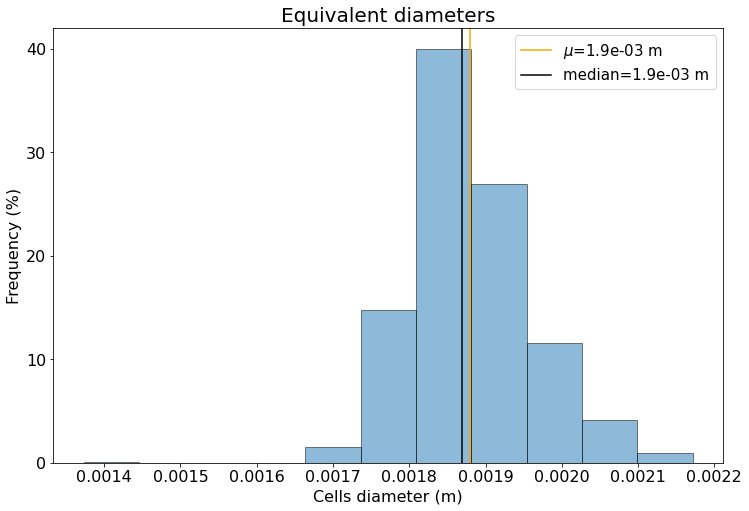

In [23]:
gap = size*0.06
c_in, idx = in_bb(c,(gap,)*3,((size-gap),)*3)
r_in = r[idx]

wgt= np.ones(len(r_in))*100 / len(r_in)
dconv = (2*50e-6)

fig1, ax1 = plt.subplots(figsize=(12,8))

binss = int( np.round( np.log2( len( r_in ) ) + 1) )
count, edges, plot = ax1.hist(r_in*dconv, bins=binss,ec='k', alpha=0.5,  weights=wgt)

ax1.axvline(x=r_in.mean()*dconv, label=r'$\mu$={:.1e} m'.format(r_in.mean()*dconv), c='orange')
ax1.axvline(x=np.median(r_in)*dconv, label='median={:.1e} m'.format(np.median(r_in)*dconv), c='k')

plt.title('Equivalent diameters', fontsize=20)

ax1.legend(fontsize=15)
ax1.set_xlabel('Cells diameter (m)',fontsize=16)
ax1.set_ylabel('Frequency (%)',fontsize=16)
ax1.set_facecolor('w')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.locator_params(axis='y', nbins=8)

fig1.savefig('./plots_pics/Al2O3_40PPI_PlugIM_Cells_equivalent.svg', facecolor='w', bbox_inches='tight')
fig1.savefig('./plots_pics/Al2O3_40PPI_PlugIM_Cells_equivalent.png', facecolor='w', bbox_inches='tight')
# bnC1 = (np.ediff1d(edges)/2)+edges[:-1]
# bnPc1 = count*100/sum(count)

# plt.title('Equivalent diameters (vx)', fontsize=20)
# for x1,y1,l1 in zip(bnC1, count, bnPc1):
#     plt.text(x1*0.98, y1+5, '{:.1f}'.format(l1), fontsize=15, rotation=0)
    
print(r_in.shape)

(1312,)


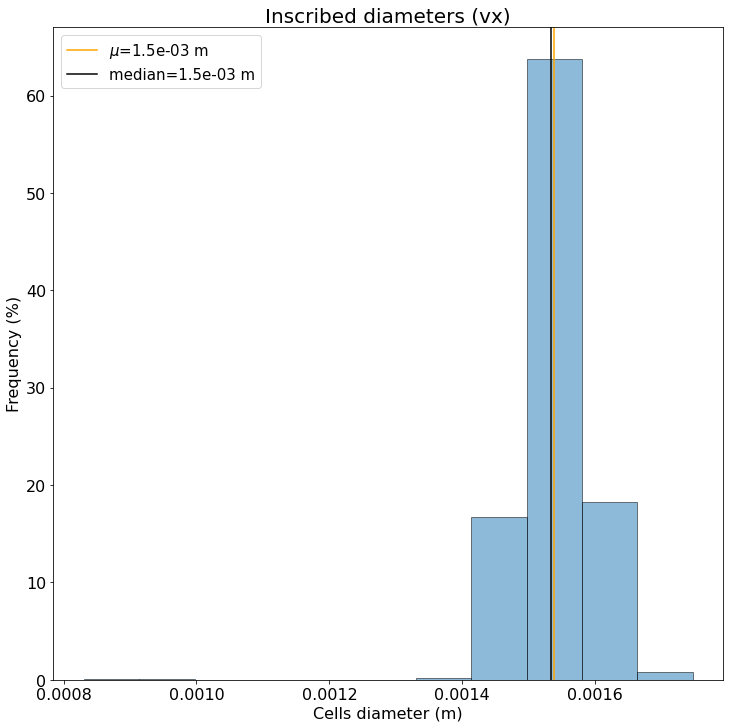

In [24]:
gap = size*0.06
c1_in, idx = in_bb(c1,(gap,)*3,((size-gap),)*3)
r1_in = r1[idx]

wgt= np.ones(len(r1_in))*100 / len(r1_in)
dconv = (2*50e-6)

fig1, ax1 = plt.subplots(figsize=(12,12))

binss = int( np.round( np.log2( len( r1_in ) ) + 1) )
count, edges, plot = ax1.hist(r1_in*dconv, bins=binss,ec='k', alpha=0.5, weights=wgt)

plt.title('Inscribed diameters (vx)', fontsize=20)


ax1.axvline(x=r1_in.mean()*dconv, label=r'$\mu$={:.1e} m'.format(r1_in.mean()*dconv), c='orange')
ax1.axvline(x=np.median(r1_in)*dconv, label='median={:.1e} m'.format(np.median(r1_in)*dconv), c='k')

ax1.legend(fontsize=15)
ax1.set_xlabel('Cells diameter (m)',fontsize=16)
ax1.set_ylabel('Frequency (%)',fontsize=16)
ax1.set_facecolor('w')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.locator_params(axis='y', nbins=8)

fig1.savefig('./plots_pics/Al2O3_40PPI_PlugIM_Cells_inscribed.svg', facecolor='w', bbox_inches='tight')
fig1.savefig('./plots_pics/Al2O3_40PPI_PlugIM_Cells_inscribed.png', facecolor='w', bbox_inches='tight')

# bnC1 = (np.ediff1d(edges)/2)+edges[:-1]
# bnPc1 = count*100/sum(count)
# for x1,y1,l1 in zip(bnC1, count, bnPc1):
#     plt.text(x1*0.98, y1+5, '{:.1f}'.format(l1), fontsize=15, rotation=0)
    
print(r1_in.shape)

In [25]:
cw = snowVox.network['throat.global_peak']
rw = snowVox.network['throat.equivalent_diameter']/2

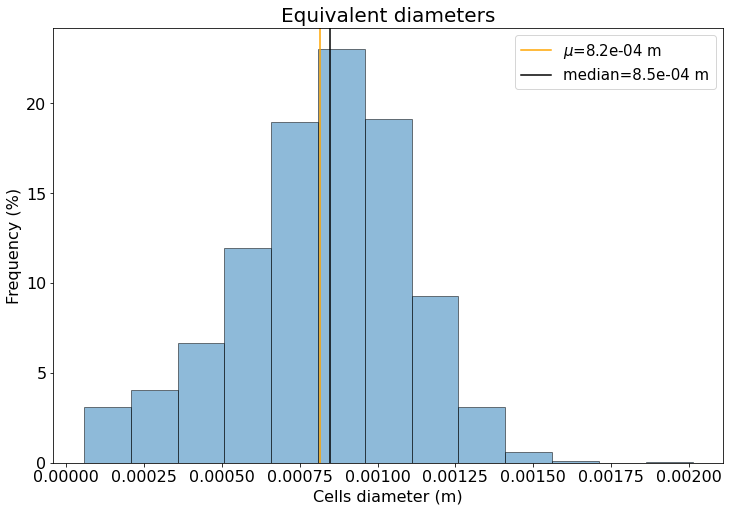

In [26]:
gap = size*0.06
cw_in, idx = in_bb(cw,(gap,)*3,((size-gap),)*3)
rw_in = rw[idx]

wgt= np.ones(len(rw_in))*100 / len(rw_in)
dconv = (2*50e-6)

fig1, ax1 = plt.subplots(figsize=(12,8))

binss = int( np.round( np.log2( len( rw_in ) ) + 1) )
count, edges, plot = ax1.hist(rw_in*dconv, bins=binss,ec='k', alpha=0.5,  weights=wgt)

ax1.axvline(x=rw_in.mean()*dconv, label=r'$\mu$={:.1e} m'.format(rw_in.mean()*dconv), c='orange')
ax1.axvline(x=np.median(rw_in)*dconv, label='median={:.1e} m'.format(np.median(rw_in)*dconv), c='k')

plt.title('Equivalent diameters', fontsize=20)

ax1.legend(fontsize=15)
ax1.set_xlabel('Cells diameter (m)',fontsize=16)
ax1.set_ylabel('Frequency (%)',fontsize=16)
ax1.set_facecolor('w')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.locator_params(axis='y', nbins=8)


#### Struts

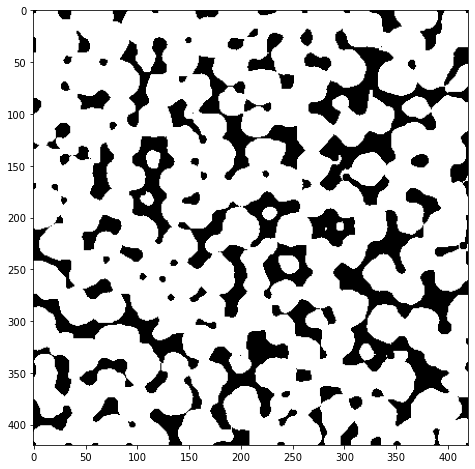

In [27]:
figf, axf = plt.subplots(figsize=(8,8))
axf.imshow(1-im765[250,:,:], cmap=cm.binary)

In [28]:
cs = snows.network['pore.coords']
rs = snows.network['pore.equivalent_diameter']/2
cs1 = snows.network['throat.global_peak']
rs1 = snows.network['throat.equivalent_diameter']/2

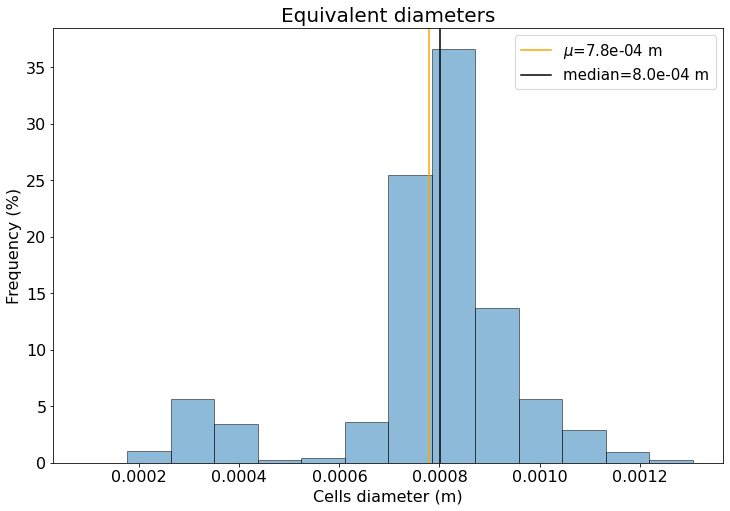

In [29]:
gap = size*0.06
cs_in, idx = in_bb(cs,(gap,)*3,((size-gap),)*3)
rs_in = rs[idx]

wgt= np.ones(len(rs_in))*100 / len(rs_in)
dconv = (2*50e-6)

fig1, ax1 = plt.subplots(figsize=(12,8))

binss = int( np.round( np.log2( len( rs_in ) ) + 1) )
count, edges, plot = ax1.hist(rs_in*dconv, bins=binss,ec='k', alpha=0.5,  weights=wgt)

ax1.axvline(x=rs_in.mean()*dconv, label=r'$\mu$={:.1e} m'.format(rs_in.mean()*dconv), c='orange')
ax1.axvline(x=np.median(rs_in)*dconv, label='median={:.1e} m'.format(np.median(rs_in)*dconv), c='k')

plt.title('Equivalent diameters', fontsize=20)

ax1.legend(fontsize=15)
ax1.set_xlabel('Cells diameter (m)',fontsize=16)
ax1.set_ylabel('Frequency (%)',fontsize=16)
ax1.set_facecolor('w')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.locator_params(axis='y', nbins=8)

In [41]:
print('mean:',rs_in.mean()*dconv)
print('std',rs_in.std()*dconv)

mean: 0.00037169541414086425
std 0.00014553761719436332


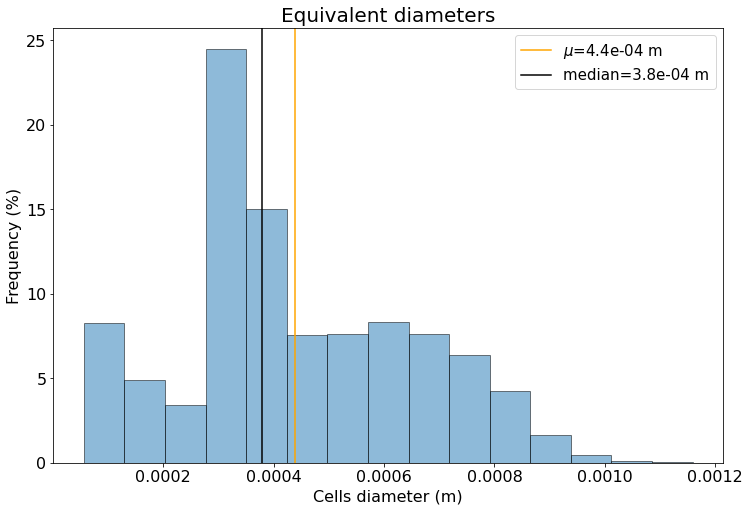

In [30]:
gap = size*0.06
cs_in, idx = in_bb(cs1,(gap,)*3,((size-gap),)*3)
rs_in = rs1[idx]

wgt= np.ones(len(rs_in))*100 / len(rs_in)
dconv = (2*50e-6)

fig1, ax1 = plt.subplots(figsize=(12,8))

binss = int( np.round( np.log2( len( rs_in ) ) + 1) )
count, edges, plot = ax1.hist(rs_in*dconv, bins=binss,ec='k', alpha=0.5,  weights=wgt)

ax1.axvline(x=rs_in.mean()*dconv, label=r'$\mu$={:.1e} m'.format(rs_in.mean()*dconv), c='orange')
ax1.axvline(x=np.median(rs_in)*dconv, label='median={:.1e} m'.format(np.median(rs_in)*dconv), c='k')

plt.title('Equivalent diameters', fontsize=20)

ax1.legend(fontsize=15)
ax1.set_xlabel('Cells diameter (m)',fontsize=16)
ax1.set_ylabel('Frequency (%)',fontsize=16)
ax1.set_facecolor('w')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.locator_params(axis='y', nbins=8)

In [43]:
print('mean:',rs_in.mean()*dconv)
print('std',rs_in.std()*dconv)

mean: 0.00024266814916499836
std 0.00014376999974251485
